In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DATA

In [2]:
df = pd.read_csv("gene_expression.csv")
df[:5]

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

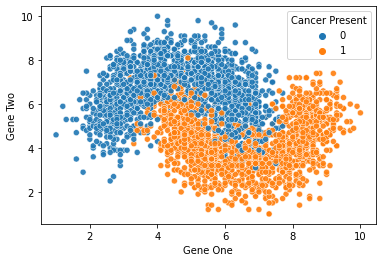

In [3]:
sns.scatterplot(x="Gene One",
                y="Gene Two",
                hue="Cancer Present",
                data=df,
                alpha=.9)

(3.0, 10.0)

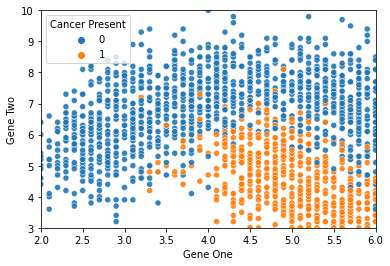

In [4]:
sns.scatterplot(x="Gene One",
                y="Gene Two",
                hue="Cancer Present",
                data=df,
                alpha=.9)
plt.xlim(2,6)
plt.ylim(3,10)

# Train and Split and Scaling Data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
X = df.drop("Cancer Present", axis=1)
y = df["Cancer Present"]

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=.3,
                                                random_state=42)

In [8]:
scaler = StandardScaler()

In [9]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
knn_model = KNeighborsClassifier(n_neighbors = 1)

In [55]:
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

## Understanding KNN & choose K value

In [56]:
full_test = pd.concat([X_test,y_test],axis=1)
len(full_test)

900

<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

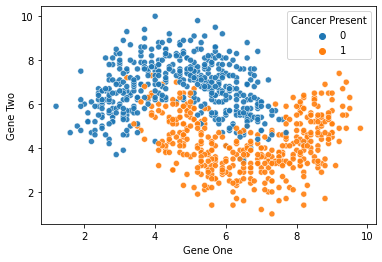

In [57]:
sns.scatterplot(x="Gene One",
                y="Gene Two",
                hue="Cancer Present",
                data=full_test,
                alpha=.9)

# Model Evaluation

In [58]:
y_pred = knn_model.predict(scaled_X_test)

In [59]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [60]:
accuracy_score(y_test, y_pred)

0.9011111111111111

In [61]:
confusion_matrix(y_test, y_pred)

array([[426,  44],
       [ 45, 385]], dtype=int64)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



## For Choosing Reasonable "K" Values
# Elbow Method

In [71]:
test_error_rates = []

for k in range(1,30):
    knn_model  = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(scaled_X_train,y_train)
    
    y_pred_test = knn_model.predict(scaled_X_test)
    test_error = 1-accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

In [73]:
test_error_rates

[0.09888888888888892,
 0.09777777777777774,
 0.07333333333333336,
 0.0755555555555556,
 0.07222222222222219,
 0.06444444444444442,
 0.06444444444444442,
 0.061111111111111116,
 0.05777777777777782,
 0.06222222222222218,
 0.061111111111111116,
 0.06000000000000005,
 0.061111111111111116,
 0.06222222222222218,
 0.05888888888888888,
 0.05777777777777782,
 0.05666666666666664,
 0.05555555555555558,
 0.05222222222222217,
 0.053333333333333344,
 0.054444444444444406,
 0.05111111111111111,
 0.054444444444444406,
 0.054444444444444406,
 0.05666666666666664,
 0.05555555555555558,
 0.05555555555555558,
 0.05777777777777782,
 0.05666666666666664]

Text(0, 0.5, 'Error Rates')

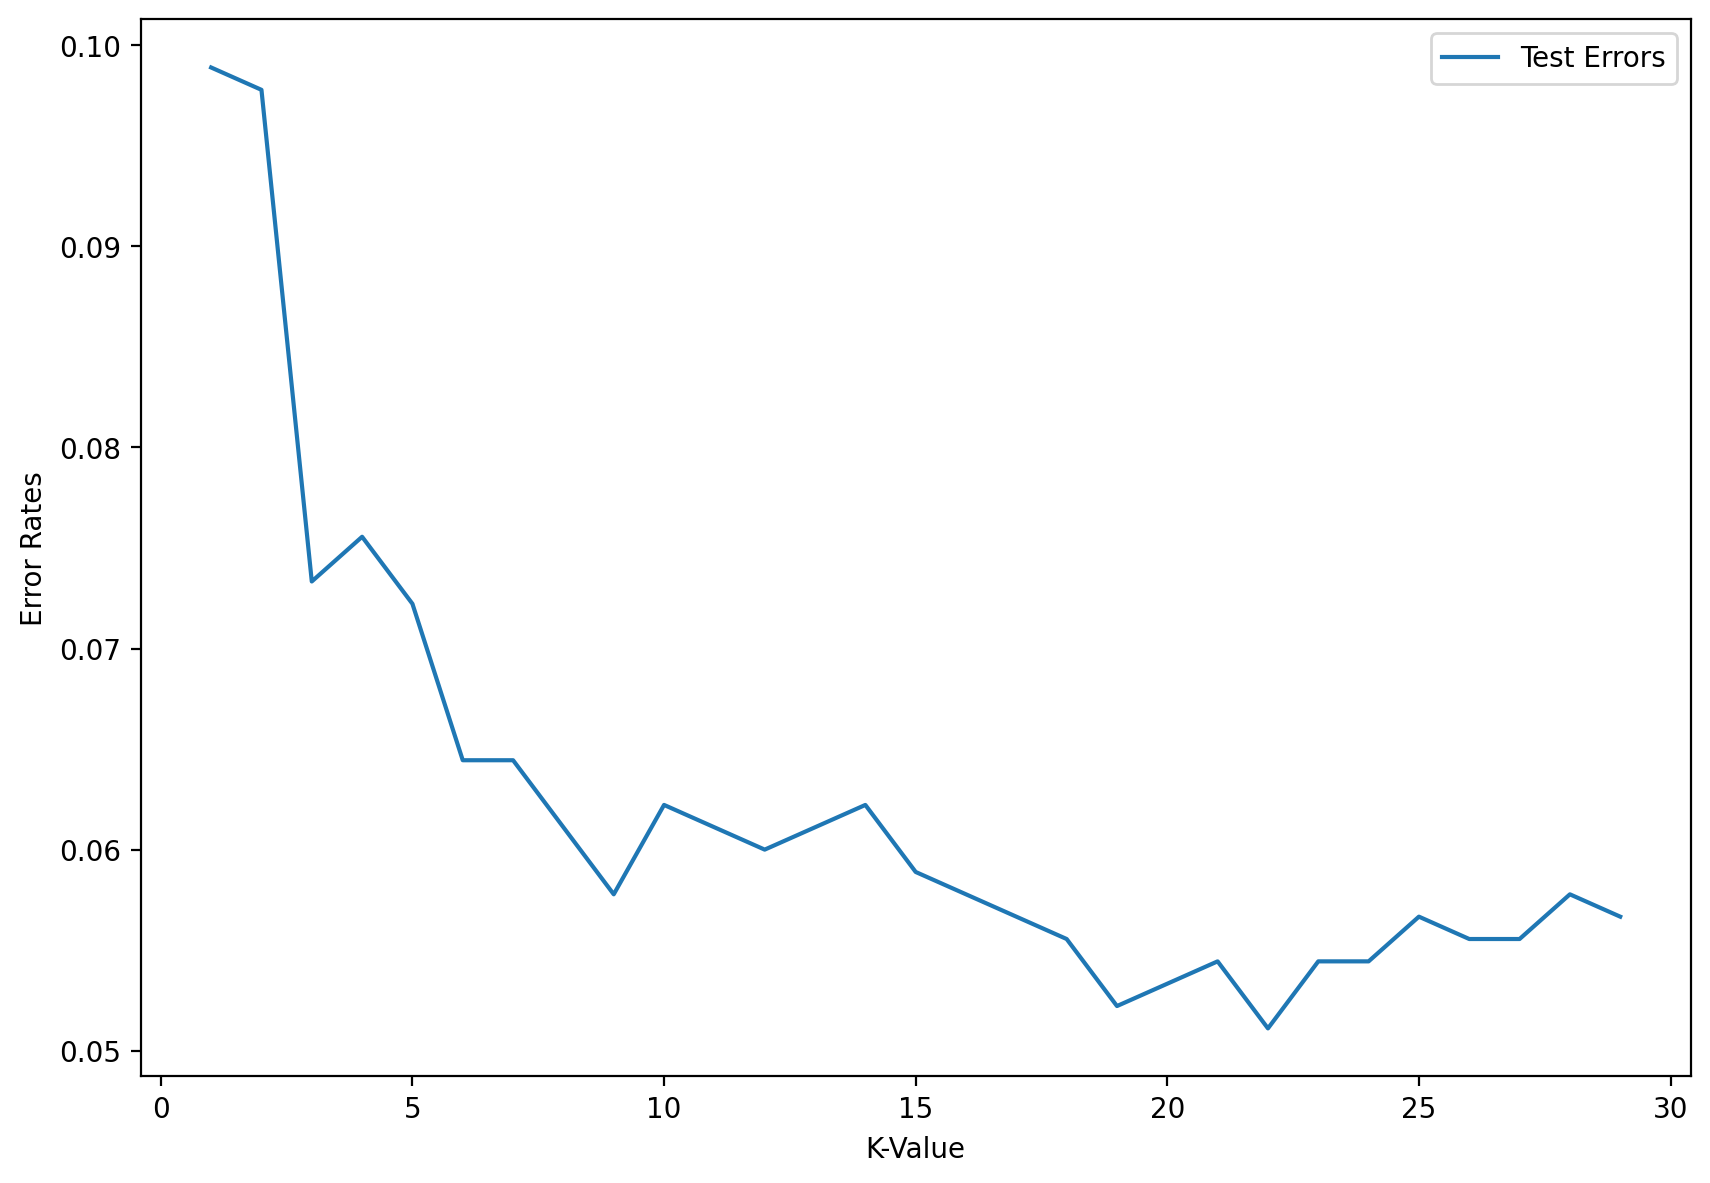

In [72]:
plt.figure(figsize = (10,7), dpi = 200)
plt.plot(range(1,30), test_error_rates,label = "Test Errors")
plt.legend()
plt.xlabel("K-Value")
plt.ylabel("Error Rates")

## Full Cross-validation Grid search for "K" values

In [76]:
scaler = StandardScaler()

In [78]:
knn = KNeighborsClassifier()

In [80]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [81]:
operation = [("scaler",scaler),("knn",knn)]

In [83]:
from sklearn.pipeline import Pipeline

In [85]:
pipe = Pipeline(operation)

In [86]:
from sklearn.model_selection import GridSearchCV

NOTE: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:*  

chosen_string_name + two underscores + parameter key name
model_name + __ + parameter name
knn_model + __ + n_neighbors
knn_model__n_neighbors  
StackOverflow on this

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

In [88]:
k_values = list(range(1,20))
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [89]:
param_grid = {"knn__n_neighbors":k_values}

In [92]:
full_cv_classifier = GridSearchCV(pipe,
                                  param_grid,
                                  cv = 5,
                                  scoring = "accuracy")

In [93]:
#help(GridSearchCV)

In [101]:
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [103]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [104]:
scaler = StandardScaler()
knn14 = KNeighborsClassifier(n_neighbors = 14)
operations = [("scaler",scaler),("knn14",knn14)]

In [105]:
pipe = Pipeline(operations)

In [106]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn14', KNeighborsClassifier(n_neighbors=14))])

In [107]:
pipe_pred = pipe.predict(X_test)

In [108]:
print(classification_report(y_test, pipe_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [109]:
single_sample = X_test.iloc[40]

In [110]:
single_sample

Gene One    3.8
Gene Two    6.3
Name: 194, dtype: float64

In [112]:
pipe.predict(single_sample.values.reshape(1,-1))

C:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [115]:
# probability of the data...
pipe.predict_proba(single_sample.values.reshape(1,-1))

C:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.92857143, 0.07142857]])